In [82]:
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

### Data

In [83]:
def load_data(file):
    ans = {}
    last = ""
    with open(file) as f:
        for line in f:
            tmp = line.strip().split()
            
            if tmp[0] == 'NAME:':
                ans['name'] = tmp[1]
                last = tmp[0]
            
            elif tmp[0] == "DIMENSION:":
                ans['n'] = int(tmp[1])
                last = tmp[0]
                
            elif tmp[0] == "DIMENSION":
                ans['n'] = int(tmp[2]) # the files with opt tour are different....
                last = tmp[0]
            
            elif tmp[0] == "EDGE_WEIGHT_SECTION":
                last = tmp[0]
            
            elif tmp[0] == "DISPLAY_DATA_SECTION" or tmp[0] == "NODE_COORD_SECTION":
                last = tmp[0]
            
            #in case we are reading the optimal tour file
            elif tmp[0] == "TOUR_SECTION": 
                last = tmp[0]
            
            elif tmp[0] == "EOF":
                last = tmp[0]
                break
                
            else:
                if last == "EDGE_WEIGHT_SECTION":
                    tmp = np.array( list ( map ( int, tmp ) ) )
                    #if our distance matrix is not fully given
                    if len(tmp) < 29: 
                        tmp = np.hstack((np.zeros( 29 - len(tmp)), tmp))
                        
                    if 'dist' in ans:
                        ans['dist'] = np.vstack((ans['dist'], tmp))
                    else:
                        ans['dist'] = tmp
                    
                if last == "DISPLAY_DATA_SECTION" or last == "NODE_COORD_SECTION":
                    tmp = list ( map ( float, tmp[1:] ) )
                    if 'coords' in ans:
                        ans['coords'] = np.vstack((ans['coords'], np.array(tmp)) )
                    else:
                        ans['coords'] = np.array(tmp)
                
                if last == "TOUR_SECTION" and tmp[0] != '-1':
                    tmp = int(tmp[0])
                    if 'p' in ans:
                        ans['p'].append(tmp - 1)
                    else:
                        ans['p'] = [tmp - 1]
    return ans

In [224]:
def plot_costs(c_min, data, opt, name):
    plt.figure(figsize=(12,4))
    plt.title(f'Costs of {name}\nfound minimum: {c_min:.3f}, optimal:{opt:.3f}', fontdict = {'fontsize' : 20})
    plt.plot(data[:,0], label="Top scores")
    plt.plot(data[:,1], label="Mean scores")
    plt.plot(data[:,2], label="Worst scores")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.legend(loc='upper right')
    plt.show()

    
def plot_histogram(costs):
    plt.figure(figsize=(12,4))
    plt.xlim(7500, 9200)
    plt.hist(costs, bins=150)
    plt.title("Histogram of costs")
    plt.xlabel("Cost")
    plt.ylabel("Number of results")
    plt.show()
    

### Operators

In [148]:
#Partialy Mapped Crossover
def PMX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = {p1[k] : p2[k] for k in range(len(p1))}
    d_p2 = {p2[k] : p1[k] for k in range(len(p2))}
    child1 = ind1.copy()
    child2 = ind2.copy()
    
    child1[i:j+1] = p2
    child2[i:j+1] = p1
    
    for k in range(i):
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
            
    for k in range(j+1, len(ind1)):
        s = 0
        while child1[k] in d_p2:
            child1[k] = d_p2[child1[k]]
            
        while child2[k] in d_p1:
            child2[k] = d_p1[child2[k]]
        
    return child2, child1

In [149]:
#Order Crossover
def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    g_start, g_end = a.min(), a.max() # index of group split
    
    groups = []
    if g_start > 0:
        groups.append((0, g_start - 1))
    groups.append((g_start, g_end))
    if g_end < len(ind1) - 1:
        groups.append((g_end + 1, len(ind1) - 1))
        
    # rand index of group we want to inherit
    r = np.random.choice(len(groups))
    i, j = groups[r][0], groups[r][1]
    
    # fragments to inherit
    p1 = ind1[i:j+1]
    p2 = ind2[i:j+1]
    d_p1 = set(p1[k] for k in range(len(p1)))
    d_p2 = set(p2[k] for k in range(len(p2)))
    
    child1 = list(range(len(ind1)))
    child2 = list(range(len(ind2)))
    
    el_for_c1 = []
    el_for_c2 = []
    
    for k in range(j + 1, len(ind1)):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    for k in range(0, j + 1):
        if ind2[k] not in d_p1:
            el_for_c1.append(ind2[k])
        if ind1[k] not in d_p2:
            el_for_c2.append(ind1[k])
    
    child1[i:j+1] = p1
    child2[i:j+1] = p2
    
    idx = 0
    
    for k in range(j + 1, len(ind1)):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
    
    for k in range(0, i):
        child1[k] = el_for_c1[idx]
        child2[k] = el_for_c2[idx]
        idx += 1
        
    return child1, child2

The Cycle Crossover operator identifies a number of so-called cycles between two parent chromosomes. Then, to form Child 1, cycle one is copied from parent 1, cycle 2 from parent 2, cycle 3 from parent 1, and so on.

In [144]:
def CX(ind1, ind2):
    d1 = {ind1[k] : k for k in range(len(ind1))}
    #d2 = {ind2[k] : k for k in range(len(ind2))}
    
    child1 = list(range(len(ind1)))
    child2 = list(range(len(ind2)))
    
    # elements of cycles
    elements = set()
    
    # find start of cycle
    parent = -1
    for i in range(len(ind1)):
        if ind1[i] not in elements:
            parent *= -1
            idx = i
            first = True
            while idx != i or first:
                first = False
                elements.add(ind1[idx])
                if parent == 1:
                    child1[idx] = ind1[idx]
                    child2[idx] = ind2[idx]
                else:
                    child1[idx] = ind2[idx]
                    child2[idx] = ind1[idx]

                idx = d1[ind2[idx]]
                
    return child1, child2

informations about crossovers:
https://www.researchgate.net/publication/226665831_Genetic_Algorithms_for_the_Travelling_Salesman_Problem_A_Review_of_Representations_and_Operators#pf14

In [173]:
# Position based crossover
# We choose randomly (with ppb 0.5) positions from parent 1
# which will be inherited by child1
def PBX(ind1, ind2):
    prob = np.random.rand(len(ind1))
    pos = prob < 0.5
    d1 = set(np.array(ind1)[pos])
    d2 = set(np.array(ind2)[pos])
    
    it1 = 0
    it2 = 0
    
    child1 = ind2.copy()
    child2 = ind1.copy()
    
    for i in range(len(ind1)):
        if not pos[i]:

            while ind1[it1] in d2:
                
                it1 += 1
            while ind2[it2] in d1:
                it2 += 1
            
            child1[i] = ind1[it1]
            child2[i] = ind2[it2]
            it1 += 1
            it2 += 1
    
    return child1, child2

### SGA algorithm

In [87]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [88]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [178]:
def SGA(F, operator = PMX, number_of_iterations = 250, return_chromosome = False):
    population_size = 500
    chromosome_length = n
    number_of_offspring = population_size
    crossover_probability = 0.95
    mutation_probability = 0.25

    time0 = time.time()

    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))
    
    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = tsp_objective_function(current_population[i, :])
    
    costs = np.zeros((number_of_iterations, 3)) # we will keep best, mean and worst cost in i-th iteration
    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = operator(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = F(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = tsp_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]
        
        # recording some statistics
        
        costs[t][0] = objective_values[0]
        costs[t][1] = objective_values.mean()
        costs[t][2] = objective_values[-1]
        
        if best_objective_value > objective_values[0]:
            best_objective_value = objective_values[0]
            best_chromosome = current_population[0, :]
    
        #print(best_chromosome)
        #print('%3d %14.8f %12.8f %12.8f %12.8f %12.8f' % (t, time.time() - time0, objective_values.min(), objective_values.mean(), objective_values.max(), objective_values.std()))
    #print("s_g_a time:", time.time() - time0)
    if return_chromosome:
        return best_objective_value, costs, best_chromosome
    return best_objective_value, costs

### Berlin52

In [179]:
data = load_data("berlin52.tsp.txt")
n = data['n']
print('Problem size: %d' % n)

coords = data['coords']

# compute a distance matrix
A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())

opt = load_data("berlin52.opt.tour.txt")
p = opt['p']
opt = tsp_objective_function(p)

print(opt, ' -> optimal solution:\n', p)


Problem size: 52
7544.365901904086  -> optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


In [180]:
data = {} # dict of operator: list of (c_min, costs) in i-th iteration
data['pmx'] = list()
for i in range(100):
    data['pmx'].append(SGA(reverse_sequence_mutation, operator = PMX))

In [181]:
data['ox'] = list()
for i in range(100):
    data['ox'].append(SGA(reverse_sequence_mutation, operator = OX))

In [182]:
data['cx'] = list()
for i in range(100):
    data['cx'].append(SGA(reverse_sequence_mutation, operator = CX))

In [183]:
data['pbx'] = list()
for i in range(100):
    data['pbx'].append(SGA(reverse_sequence_mutation, operator = PBX))

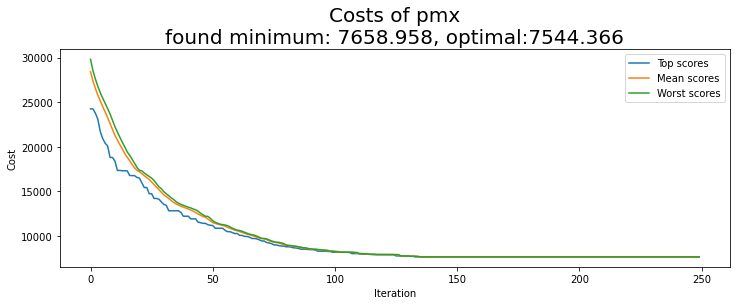

Mean: 8183.37343031151, Std: 227.06454646961333


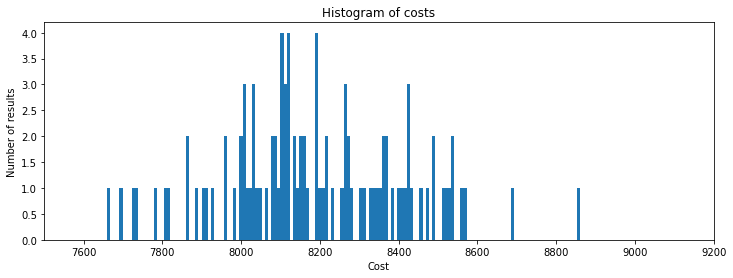

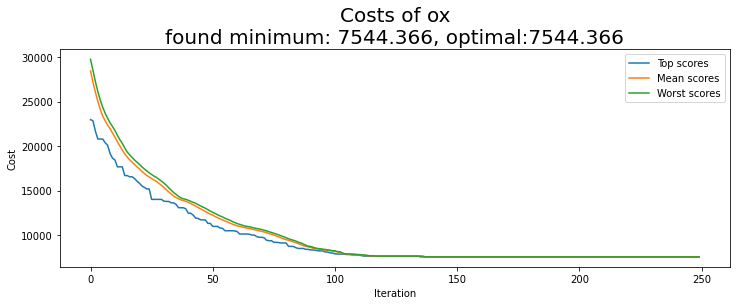

Mean: 8041.7095840067395, Std: 222.76881760790633


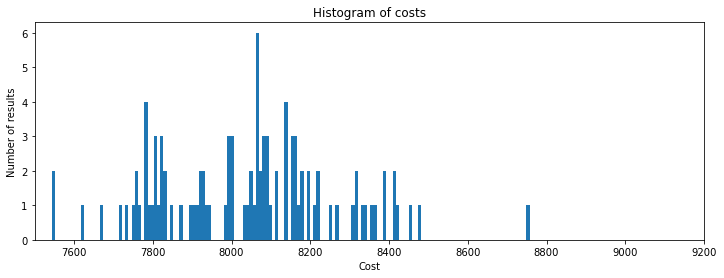

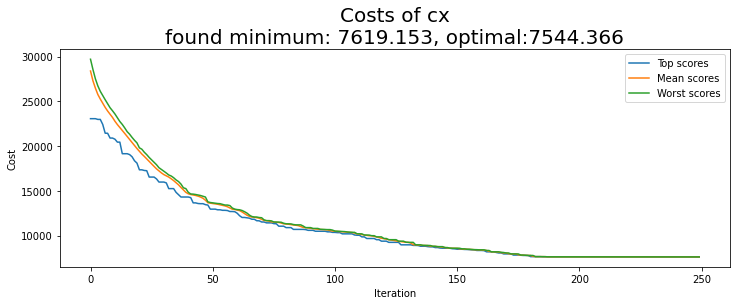

Mean: 8197.102111292106, Std: 260.14026232689304


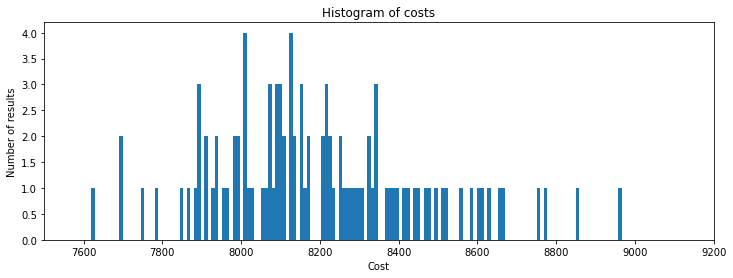

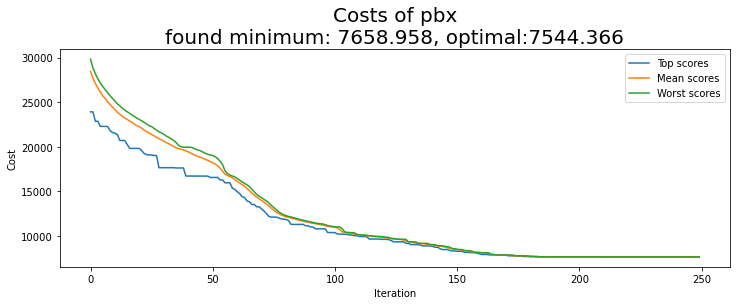

Mean: 8202.900570659218, Std: 265.60596972264216


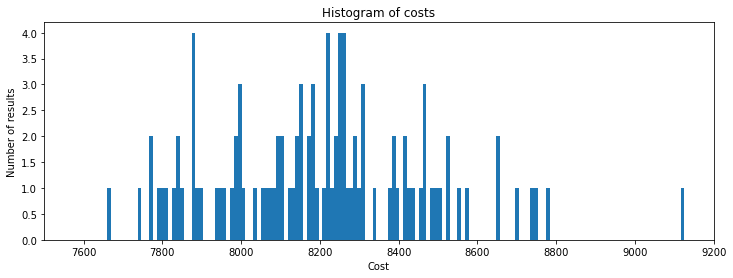

In [225]:
avgs = []
for op in ['pmx', 'ox', 'cx', 'pbx']:
    data[op].sort(key = lambda k: k[0])
    plot_costs(data[op][0][0], data[op][0][1], opt, op)
    costs = np.array([c[0] for c in data[op]])
    avgs.append(costs.mean())
    print(f'Mean: {costs.mean()}, Std: {costs.std()}')
    plot_histogram(costs)

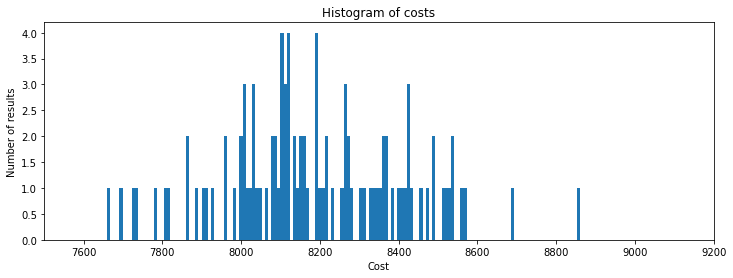

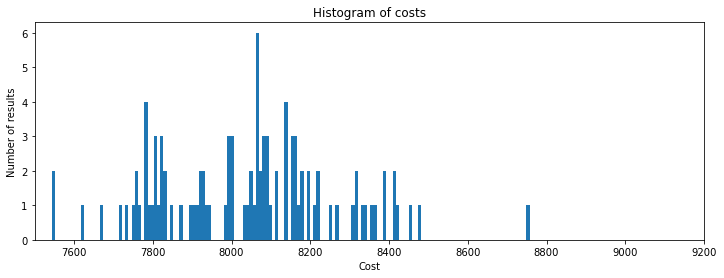

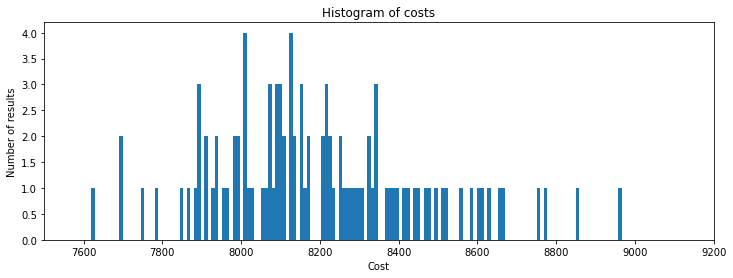

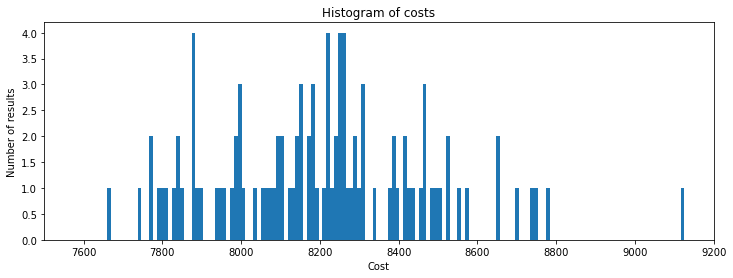

In [226]:
for op in ['pmx', 'ox', 'cx', 'pbx']:
    costs = np.array([c[0] for c in data[op]])
    plot_histogram(costs)

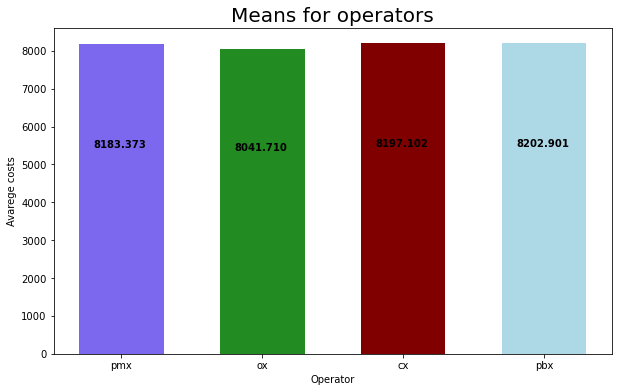

In [213]:
# compare the means of methods by bar plot
plt.figure(figsize=(10,6))
plt.title('Means for operators', fontdict = {'fontsize' : 20})
plt.bar(['pmx', 'ox', 'cx', 'pbx'], avgs, color = ('mediumslateblue', 'forestgreen', 'maroon', 'lightblue'), width = 0.6)
for i, a in enumerate(avgs):
    plt.text(i - 0.2, 2 * a / 3, f'{a:.3f}', color = 'black', fontweight='bold')
plt.xlabel("Operator")
plt.ylabel("Avarege costs")
plt.show()